In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import pbdlib as pbd

%matplotlib inline
%load_ext autoreload
%autoreload 2

from pbdlib.utils.jupyter_utils import *
np.set_printoptions(precision=2)

2023-03-14 14:47:14.729473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 14:47:14.814618: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-14 14:47:14.814632: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-14 14:47:15.156863: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Hidden Markov Model in Multiple coordinate systems (HMM)

This example shows how motions can adapt to various positions and orientations of objects by projecting the demonstrations in several coordinate systems.

See http://calinon.ch/papers/Calinon-JIST2015.pdf

### Loading data 

In [3]:
filename = 'reach_target'

pbd_path = os.path.dirname(pbd.__file__) + '/data/gui/'

demos = np.load(pbd_path + filename + '.npy', allow_pickle=True, encoding='latin1')[()]

print(demos.keys())

### Trajectory data
demos_x = demos['x'] # position
print(len(demos_x), demos_x[0].shape)
demos_dx = demos['dx'] # velocity
demos_xdx = [np.concatenate([x, dx], axis=1) for x, dx in zip(demos_x, demos_dx)] # concatenation
print("demos_xdx", len(demos_xdx), demos_xdx[0].shape, demos_xdx[1].shape)

### Coordinate systems transformation
demos_A = [d for d in demos['A']]
demos_b = [d for d in demos['b']]

print(len(demos_A), demos_A[0].shape, len(demos_x), demos_x[0].shape)

### Coordinate systems transformation for concatenation of position-velocity
demos_A_xdx = [np.kron(np.eye(2), d) for d in demos_A]
demos_b_xdx = [np.concatenate([d, np.zeros(d.shape)], axis=-1) for d in demos_b]
print(len(demos_A_xdx), demos_A_xdx[0].shape, demos_b_xdx[0].shape)

dict_keys(['A', 'x', 'b', 'obj_x', 'dx'])
9 (72, 2)
demos_xdx 9 (72, 4) (80, 4)
9 (72, 2, 2, 2) 9 (72, 2)
9 (72, 2, 4, 4) (72, 2, 4)


In [4]:
### Stacked demonstrations
data_x = np.concatenate([d for d in demos_x], axis=0)

print(data_x.shape)

ylim = [np.min(data_x[:, 1]) - 20., np.max(data_x[:, 1]) + 20]
xlim = [np.min(data_x[:, 0]) - 20., np.max(data_x[:, 0]) + 20]

(747, 2)


### Projection in the different coordinate systems
$x^{(j)}_t = A^{(j)T}_t(x-b_t^{(j)})$

In [5]:
print(len(demos_xdx), demos_xdx[0].shape)
print(len(demos_A_xdx), demos_A_xdx[0].shape)

9 (72, 4)
9 (72, 2, 4, 4)


In [6]:
# a new axis is created for the different coordinate systems 
demos_xdx_f = [np.einsum('taji,taj->tai',_A, _x[:, None] - _b) 
               for _x, _A, _b in zip(demos_xdx, demos_A_xdx, demos_b_xdx)] 
# t : timestep, a coordinate systems, i, j : dimensions

# concatenated version of the coordinate systems
demos_xdx_augm = [d.reshape(-1, 8) for d in demos_xdx_f]

print(len(demos_xdx_augm), demos_xdx_augm[0].shape, demos_xdx_f[0].shape)

9 (72, 8) (72, 2, 4)


###  Learning model

0.001
EM did not converge
(4, 8) (4, 8, 8)


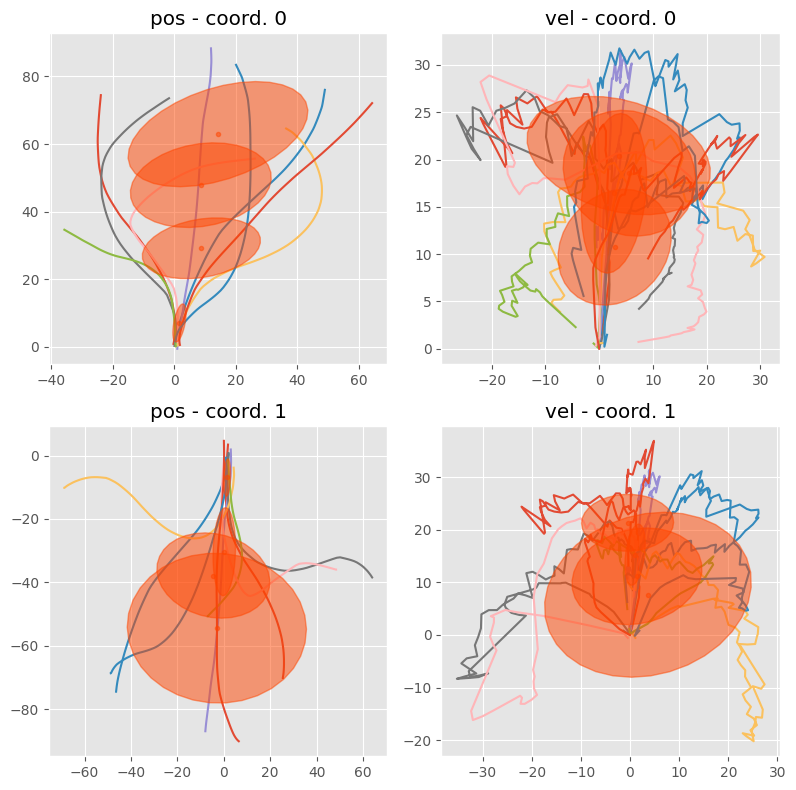

In [7]:
model = pbd.HMM(nb_states=4, nb_dim=8)

model.init_hmm_kbins(demos_xdx_augm) # initializing model

# EM to train model
model.em(demos_xdx_augm, reg=1e-3) 

print(model.mu.shape, model.sigma.shape)

# plotting
fig, ax = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(8,8)

for j in range(2):
    # position plotting
    ax[j, 0].set_title('pos - coord. %d' % j)
    for p in demos_xdx_f:
        ax[j, 0].plot(p[:,j, 0], p[:, j, 1])

    pbd.plot_gmm(model.mu, model.sigma, ax=ax[j, 0], dim=[0+j*4, 1+j*4], color='orangered'); 

    # velocity plotting

    ax[j, 1].set_title('vel - coord. %d' % j)
    for p in demos_xdx_f:
        ax[j, 1].plot(p[:, j, 2], p[:, j, 3])

    pbd.plot_gmm(model.mu, model.sigma, ax=ax[j, 1], dim=[2+j*4, 3+j*4], color='orangered'); 


plt.tight_layout()

## Transforming models in a global coordinate system and product

Here we transform all the models in separate coordinate systems in a global systems and compute a compromise between them, as they were multiple experts, giving there opinions. The compromise is computed with the product of Gaussian http://www.tina-vision.net/docs/memos/2003-003.pdf.

In [8]:
import matplotlib.patches as mpatches
demo_idx = 4
# get transformation for given demonstration. 
# We use the transformation of the first timestep as they are constant
A, b = demos_A_xdx[demo_idx][0], demos_b_xdx[demo_idx][0] 

print(A.shape)

print(A[0])

# transformed model for coordinate system 1
mod1 = model.marginal_model(slice(0, 4)).lintrans(A[0], b[0])

# transformed model for coordinate system 2
mod2 = model.marginal_model(slice(4, 8)).lintrans(A[1], b[1])

# product 
prod = mod1 * mod2

(2, 4, 4)
[[ 1.  0.  0.  0.]
 [-0.  1. -0.  0.]
 [ 0.  0.  1.  0.]
 [-0.  0. -0.  1.]]


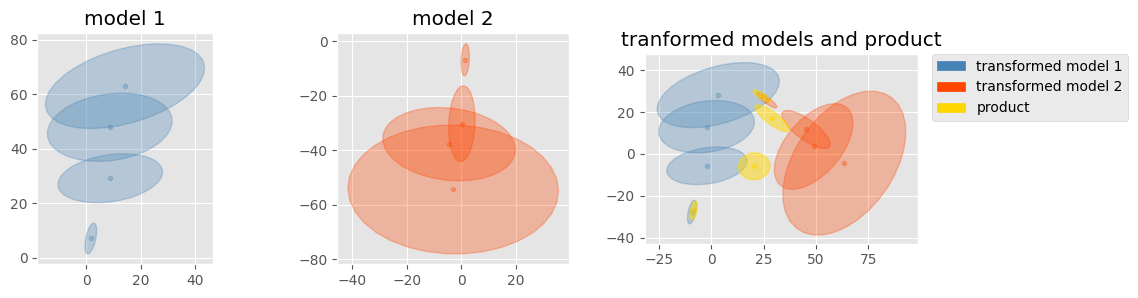

In [9]:
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches((12, 3))
for a in ax: a.set_aspect('equal')

ax[0].set_title('model 1')
pbd.plot_gmm(model.mu, model.sigma, swap=True,ax=ax[0], dim=[0, 1], color='steelblue', alpha=0.3)
ax[1].set_title('model 2')
pbd.plot_gmm(model.mu, model.sigma, swap=True,ax=ax[1], dim=[4, 5], color='orangered', alpha=0.3)

ax[2].set_title('tranformed models and product')
pbd.plot_gmm(mod1.mu, mod1.sigma, swap=True,ax=ax[2], dim=[0, 1], color='steelblue', alpha=0.3)
pbd.plot_gmm(mod2.mu, mod2.sigma, swap=True,ax=ax[2], dim=[0, 1], color='orangered', alpha=0.3)
pbd.plot_gmm(prod.mu, prod.sigma, swap=True,ax=ax[2], dim=[0, 1], color='gold')

patches = [mpatches.Patch(color='steelblue', label='transformed model 1'),
            mpatches.Patch(color='orangered', label='transformed model 2'),
            mpatches.Patch(color='gold', label='product')]

plt.legend(handles=patches,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Reproduction for each demonstration 

In [10]:
print([len(d) for d in demos_xdx_augm])

[72, 80, 82, 90, 92, 78, 86, 83, 84]


/tmp/ipykernel_135811/315333022.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fig, ax = plt.subplots(ncols=nbcol, nrows=np.ceil(float(len(demos_x))/nbcol).astype(np.int))


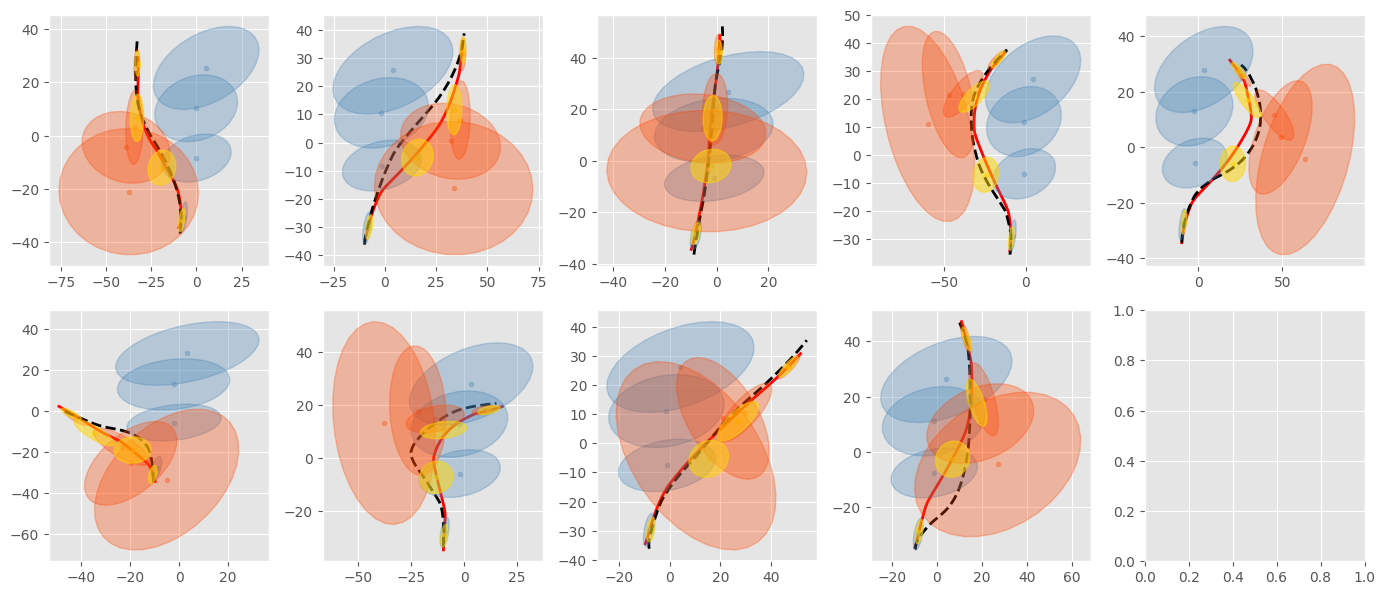

In [11]:
nbcol = 5
fig, ax = plt.subplots(ncols=nbcol, nrows=np.ceil(float(len(demos_x))/nbcol).astype(np.int))
fig.set_size_inches(14, 3 * ax.shape[0])
ax = ax.reshape(-1)

for i in range(len(demos_x)):
    _A, _b = demos_A_xdx[i][0], demos_b_xdx[i][0] 

    _mod1 = model.marginal_model(slice(0, 4)).lintrans(_A[0], _b[0])
    _mod2 = model.marginal_model(slice(4, 8)).lintrans(_A[1], _b[1])
    
    # product 
    _prod = _mod1 * _mod2
    
    # get the most probable sequence of state for this demonstration
    sq = model.viterbi(demos_xdx_augm[i])
    
    # solving LQR with Product of Gaussian, see notebook on LQR
    lqr = pbd.PoGLQR(nb_dim=2, dt=0.05, horizon=demos_xdx[i].shape[0])
    lqr.mvn_xi = _prod.concatenate_gaussian(sq) # augmented version of gaussian
    lqr.mvn_u = -4.
    lqr.x0 = demos_xdx[demo_idx][0]
    
    xi = lqr.seq_xi
    ax[i].plot(xi[:, 0], xi[:, 1], color='r', lw=2)
    
    pbd.plot_gmm(_mod1.mu, _mod1.sigma, swap=True, ax=ax[i], dim=[0, 1], color='steelblue', alpha=0.3)
    pbd.plot_gmm(_mod2.mu, _mod2.sigma, swap=True, ax=ax[i], dim=[0, 1], color='orangered', alpha=0.3)
    
    pbd.plot_gmm(_prod.mu, _prod.sigma, swap=True, ax=ax[i], dim=[0, 1], color='gold')
    
    ax[i].plot(demos_x[i][:, 0], demos_x[i][:, 1], 'k--', lw=2)

plt.tight_layout()